Text Classification on Job Postings

In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 20.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=5727306d3f6d1e1e8567e6d3054f252faa6adcdee22a5fc29c8f897e1c952c0e
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=a1a5fbe63eed1d7a77e7087c53dcff8b1e96d97ecac242bf03acaf932a76e983
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


In [49]:
import pandas as pd
import nltk
import warnings
from nltk.corpus import stopwords
import numpy as np
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
import gensim.corpora as corpora
from gensim.models import HdpModel
import time
time.clock = time.time
from gensim.models import CoherenceModel
from operator import itemgetter
import pyLDAvis.gensim_models
from gensim.models import LdaModel
import pickle 
import pyLDAvis
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from keras.layers import LSTM
from keras.layers import SpatialDropout1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import re
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
path = '/content/drive/MyDrive/AUD Project/'
df = pd.read_csv(path + "Job listings - Category education.csv")

#Glimpse of the raw scraped data
df.head()

,Link,Posting Title,Location,Category,Posting Text
0,https://boone.craigslist.org/edu/d/boone-nurse...,Nursery Staff needed at App Ski Mtn.,boone,edu,QR Code Link to This Post App Ski Mtn is cur...
1,https://asheville.craigslist.org/edu/d/candler...,Challenge Island STEAM enrichment franchise,asheville,edu,QR Code Link to This Post CHALLENGE ISLAND i...
2,https://albanyga.craigslist.org/edu/d/albany-m...,Making a difference in the Black Community. Pa...,albanyga,edu,QR Code Link to This Post We are a Black-Own...
3,https://atlanta.craigslist.org/eat/edu/d/pine-...,Childcare Teacher,atlanta,edu,QR Code Link to This Post Early childhood ed...
4,https://atlanta.craigslist.org/sat/edu/d/atlan...,Experience Childcare Teachers & Van Drivers ne...,atlanta,edu,QR Code Link to This Post Childcare Teachers...


In [52]:
#Checking shape of the dataset - before removing duplicated descriptions
df.shape

(683, 5)

In [53]:
#Removing repeating job descriptions 
df = df.apply(lambda x: x.astype(str).str.lower()).drop_duplicates(subset=['Posting Text'], keep='first')

#Checking shape of the dataset - after removing duplicated descriptions
df.shape

(649, 5)

In [54]:
#Cleaning the data

#tokenizing 

df['tokenized description'] = [nltk.word_tokenize(x) for x in df['Posting Text']]

#removing punctuations so words such as "jobs" and "jobs." are not treated separately after tokenizing

review_collection=[]
for l in df['tokenized description']:
    single_review=[]
    for word in l:
        res = re.sub(r'[^\w\s]', '', word)
        single_review.append(res)
    review_collection.append(single_review)
    
df['cleaned description'] = review_collection

#removing all the stop-words and the punctuations
#note : we have added a few highly frequent words to the stopwords list after looking at a couple of reviews

stopwords_list = stopwords.words('english')

words_to_add = ['qr','code','link','to','this','post','click','here','http','https']
stopwords_list = stopwords_list + words_to_add

stop_words_removed_description=[]
for l in df['cleaned description']:
    stop_words_removed=[] 
    stop_words_removed=[word for word in l if word.lower() not in stopwords_list if word.isalpha()]
    stop_words_removed_description.append(stop_words_removed)

df['stop_words_removed description'] = stop_words_removed_description

#removing single letters between reviews since they do not give us any information

single_letter_removed_description=[]
for l in df['stop_words_removed description']:
    single_letter_removed=[] 
    single_letter_removed=[word for word in l if len(word)!=1]
    single_letter_removed_description.append(single_letter_removed)
    
df['single_letter_removed_description'] = single_letter_removed_description

#lemmatizing the words in each review

lemmatizer = WordNetLemmatizer()
lemmatized_description=[]
for l in df['single_letter_removed_description']:
    lemmatized_words=[]
    lemmatized_words=[lemmatizer.lemmatize(word.lower()) if word.isalpha() else word.lower() for word in l ]
    lemmatized_description.append(lemmatized_words)

df['lemmatized description'] = lemmatized_description

df['final cleaned posting text'] = [' '.join(word) for word in df['lemmatized description']]
df.head()

,Link,Posting Title,Location,Category,Posting Text,tokenized description,cleaned description,stop_words_removed description,single_letter_removed_description,lemmatized description,final cleaned posting text
0,https://boone.craigslist.org/edu/d/boone-nurse...,nursery staff needed at app ski mtn.,boone,edu,qr code link to this post app ski mtn is cur...,"[qr, code, link, to, this, post, app, ski, mtn...","[qr, code, link, to, this, post, app, ski, mtn...","[app, ski, mtn, currently, hiring, nursery, st...","[app, ski, mtn, currently, hiring, nursery, st...","[app, ski, mtn, currently, hiring, nursery, st...",app ski mtn currently hiring nursery staff ski...
1,https://asheville.craigslist.org/edu/d/candler...,challenge island steam enrichment franchise,asheville,edu,qr code link to this post challenge island i...,"[qr, code, link, to, this, post, challenge, is...","[qr, code, link, to, this, post, challenge, is...","[challenge, island, looking, add, franchises, ...","[challenge, island, looking, add, franchises, ...","[challenge, island, looking, add, franchise, a...",challenge island looking add franchise across ...
2,https://albanyga.craigslist.org/edu/d/albany-m...,making a difference in the black community. pa...,albanyga,edu,qr code link to this post we are a black-own...,"[qr, code, link, to, this, post, we, are, a, b...","[qr, code, link, to, this, post, we, are, a, b...","[blackowned, organization, focuses, spreading,...","[blackowned, organization, focuses, spreading,...","[blackowned, organization, focus, spreading, a...",blackowned organization focus spreading awaren...
3,https://atlanta.craigslist.org/eat/edu/d/pine-...,childcare teacher,atlanta,edu,qr code link to this post early childhood ed...,"[qr, code, link, to, this, post, early, childh...","[qr, code, link, to, this, post, early, childh...","[early, childhood, education, toddler, year, o...","[early, childhood, education, toddler, year, o...","[early, childhood, education, toddler, year, o...",early childhood education toddler year old tea...
4,https://atlanta.craigslist.org/sat/edu/d/atlan...,experience childcare teachers & van drivers ne...,atlanta,edu,qr code link to this post childcare teachers...,"[qr, code, link, to, this, post, childcare, te...","[qr, code, link, to, this, post, childcare, te...","[childcare, teachers, general, maintenance, va...","[childcare, teachers, general, maintenance, va...","[childcare, teacher, general, maintenance, van...",childcare teacher general maintenance van driv...


In [55]:
#deleting unnecessary and intermediate columns and keeping the final cleaned posting text
df.drop(['Link', 'Location', 'Category', 'Posting Text', 'tokenized description', 'cleaned description', 'stop_words_removed description','single_letter_removed_description'], axis=1, inplace=True)
df.head()

,Posting Title,lemmatized description,final cleaned posting text
0,nursery staff needed at app ski mtn.,"[app, ski, mtn, currently, hiring, nursery, st...",app ski mtn currently hiring nursery staff ski...
1,challenge island steam enrichment franchise,"[challenge, island, looking, add, franchise, a...",challenge island looking add franchise across ...
2,making a difference in the black community. pa...,"[blackowned, organization, focus, spreading, a...",blackowned organization focus spreading awaren...
3,childcare teacher,"[early, childhood, education, toddler, year, o...",early childhood education toddler year old tea...
4,experience childcare teachers & van drivers ne...,"[childcare, teacher, general, maintenance, van...",childcare teacher general maintenance van driv...


K MEANS

In [56]:
# Trying K means to get clusters for extracting titles from the documents

#Creating tf-idf vector

education_data = list(df['final cleaned posting text'])
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3)
Tfidf_education = vectorizer.fit_transform(education_data)
print(vectorizer.vocabulary_)

{'app': 430, 'ski': 7882, 'currently': 2079, 'hiring': 3966, 'nursery': 5651, 'staff': 8061, 'season': 7627, 'duty': 2563, 'include': 4205, 'oversight': 5918, 'program': 6661, 'child': 1333, 'age': 284, 'operating': 5794, 'apply': 458, 'person': 6180, 'main': 5029, 'office': 5715, 'day': 2144, 'week': 9316, 'currently hiring': 2082, 'duty include': 2568, 'include oversight': 4214, 'program child': 6665, 'child age': 1338, 'apply person': 469, 'main office': 5030, 'day week': 2172, 'challenge': 1271, 'island': 4498, 'looking': 4932, 'add': 188, 'across': 137, 'country': 1940, 'teacher': 8551, 'love': 4980, 'kid': 4606, 'might': 5293, 'right': 7353, 'entrepreneur': 2939, 'magazine': 5024, 'named': 5490, 'one': 5738, 'top': 8881, 'world': 9587, 'run': 7424, 'inschool': 4350, 'field': 3330, 'trip': 8977, 'school': 7532, 'summer': 8397, 'camp': 1070, 'family': 3247, 'night': 5595, 'email': 2744, 'text': 8745, 'get': 3662, 'information': 4308, 'looking add': 4933, 'across country': 140, 'lov

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


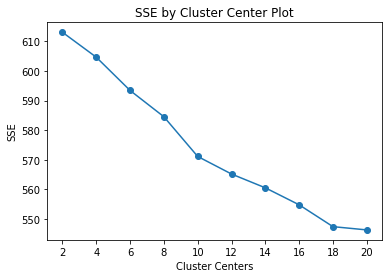

In [57]:
#Getting optimal number of clusters :

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=100).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

find_optimal_clusters(Tfidf_education, 20)

In [58]:
#10 seems to be a good choice for the number of clusters by elbow method. We can check with 10 clusters.

Kmeans_model = MiniBatchKMeans(n_clusters=10, init_size=1024, batch_size=2048, random_state=100).fit(Tfidf_education) 
Kmeans_model.cluster_centers_
Kmeans_model.fit_transform(Tfidf_education)
Kmeans_model_clusters = Kmeans_model.labels_.tolist()
print(Kmeans_model_clusters)

[9, 7, 8, 6, 6, 7, 5, 7, 1, 4, 6, 7, 9, 8, 4, 5, 5, 5, 9, 4, 4, 1, 8, 7, 5, 1, 7, 8, 4, 7, 8, 8, 5, 7, 5, 9, 5, 4, 6, 4, 4, 7, 4, 6, 8, 0, 7, 4, 9, 4, 1, 7, 4, 4, 5, 4, 8, 6, 7, 4, 7, 6, 6, 7, 0, 5, 7, 5, 5, 5, 8, 5, 5, 6, 0, 4, 9, 4, 5, 7, 7, 4, 4, 6, 7, 4, 6, 9, 0, 0, 7, 6, 5, 6, 0, 0, 7, 4, 4, 4, 7, 5, 5, 5, 4, 6, 5, 9, 4, 4, 6, 0, 5, 4, 5, 7, 5, 9, 4, 6, 0, 1, 5, 0, 0, 0, 7, 0, 0, 4, 0, 0, 6, 4, 6, 0, 9, 5, 6, 4, 0, 4, 6, 4, 5, 4, 4, 6, 4, 4, 4, 8, 5, 0, 0, 0, 7, 0, 6, 5, 4, 5, 1, 6, 6, 4, 4, 4, 0, 6, 6, 4, 0, 7, 7, 5, 5, 0, 6, 0, 4, 9, 9, 9, 9, 9, 9, 5, 6, 5, 4, 3, 3, 3, 3, 3, 3, 4, 5, 0, 7, 5, 5, 7, 6, 7, 7, 7, 6, 5, 4, 4, 5, 6, 1, 1, 1, 1, 1, 5, 5, 4, 5, 5, 4, 4, 4, 5, 4, 6, 4, 4, 4, 4, 4, 4, 5, 5, 5, 7, 7, 7, 9, 4, 4, 4, 4, 4, 4, 5, 6, 4, 4, 6, 0, 5, 6, 4, 7, 4, 5, 4, 7, 4, 4, 4, 9, 4, 7, 4, 7, 4, 5, 4, 5, 4, 5, 7, 5, 5, 9, 2, 2, 2, 2, 2, 2, 2, 4, 2, 9, 5, 6, 5, 7, 5, 5, 5, 1, 4, 7, 0, 0, 4, 4, 5, 4, 4, 4, 6, 4, 5, 6, 6, 6, 5, 4, 7, 9, 7, 4, 4, 6, 5, 5, 4, 5, 4, 9, 5, 4, 6, 4, 

In [59]:
order_centroids = Kmeans_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [60]:
#len(order_centroids) = 10
cluster_terms_list = []
for i in range(len(order_centroids)):
  print('centroid : ', i)
  terms_list = []
  for index in order_centroids[i, :20]:
     terms_list.append(terms[index])
  cluster_terms_list.append(terms_list)
  print(terms_list)

centroid :  0
['teacher', 'time', 'full time', 'de', 'full', 'paid', 'para', 'child', 'preschool', 'maestra', 'part time', 'assistant', 'care', 'hour', 'childcare', 'part', 'center', 'call', 'looking', 'daycare']
centroid :  1
['student', 'special education', 'education', 'special', 'teacher', 'school', 'director', 'academic', 'teaching', 'learning', 'instruction', 'develop', 'position', 'charter', 'ensure', 'degree', 'department education', 'charter school', 'department', 'individual']
centroid :  2
['substitute', 'substitute teacher', 'district', 'certification', 'school', 'teacher', 'insurance', 'schedule', 'day', 'onboarding process', 'onboarding', 'shift', 'job', 'benefit', 'classroom', 'teaching', 'school administration', 'dental', 'coordinator', 'hour shift']
centroid :  3
['camp', 'camper', 'ramapo', 'summer', 'day camp', 'exit', 'day', 'see', 'rt', 'wwwramapocampcom', 'saddle', 'bergen', 'specialist', 'ramapo country', 'staff', 'country day', 'run', 'country', 'saddle river', 

In [61]:
#Assigning Kmeans clusters to each document:

df['cluster'] = Kmeans_model_clusters
df.head()

,Posting Title,lemmatized description,final cleaned posting text,cluster
0,nursery staff needed at app ski mtn.,"[app, ski, mtn, currently, hiring, nursery, st...",app ski mtn currently hiring nursery staff ski...,9
1,challenge island steam enrichment franchise,"[challenge, island, looking, add, franchise, a...",challenge island looking add franchise across ...,7
2,making a difference in the black community. pa...,"[blackowned, organization, focus, spreading, a...",blackowned organization focus spreading awaren...,8
3,childcare teacher,"[early, childhood, education, toddler, year, o...",early childhood education toddler year old tea...,6
4,experience childcare teachers & van drivers ne...,"[childcare, teacher, general, maintenance, van...",childcare teacher general maintenance van driv...,6


In [62]:
#K means cluster descriptions:

#Topic 0: Pre-School/Pre-Primary
#Topic 1: Special education
#Topic 2: Substitute
#Topic 3: Summer camp
#Topic 4: Primary
#Topic 5: High-School/College
#Topic 6: Daycare
#Topic 7: Vocational Training
#Topic 8: Community/Non-Profit
#Topic 9: Nanny/Caregiver

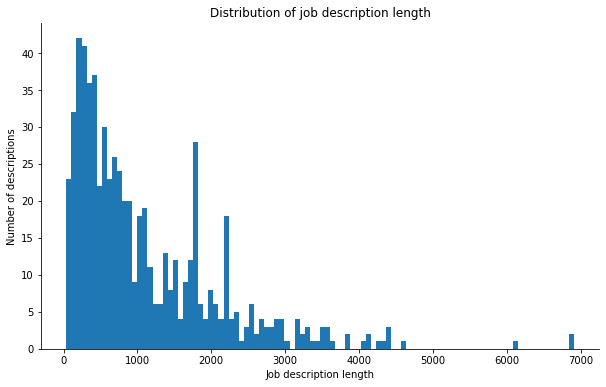

In [63]:
#Trying out other topic modeling approaches:

#3 topic modelling approaches are available:

#1. LDA : Latent Dirichlet Allocation
#2. NMF : Non-Negative Matrix Factorization
#3. HDP : Hierarchical Dirichlet process 

#HDP is an extension of LDA, designed to address the case where the number of mixture components (the number of "topics" in document-modeling terms) is not known a priori. So that's the reason why there's a difference.

#Source: https://datascience.stackexchange.com/questions/128/latent-dirichlet-allocation-vs-hierarchical-dirichlet-process#:~:text=Latent%20Dirichlet%20Allocation%20(LDA)%20and,%2C%20and%20HDP%20doesn't.

#Ideally, NMF is used for shorter texts and tweets. 

#Determining how long the job descriptions are in general:

plt.figure(figsize=(10,6))

doc_lens = [len(d) for d in df['final cleaned posting text']]
plt.hist(doc_lens, bins = 100)
plt.title('Distribution of job description length')
plt.ylabel('Number of descriptions')
plt.xlabel('Job description length')
sns.despine();

#We observe that most job descriptions are pretty long. Hence we discard the NMF method. 
#Source: https://www.researchgate.net/publication/327089757_Experimental_explorations_on_short_text_topic_mining_between_LDA_and_NMF_based_Schemes

In [64]:
#Transforming data to prepare for the input to lda model

lemmatized_description_list_of_list = list(df['lemmatized description'])

#Dictionary
id2word = corpora.Dictionary(lemmatized_description_list_of_list)
#Corpus
texts = lemmatized_description
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 3), (19, 1), (20, 1)]]


LDA

In [65]:
#Building a baseline LDA model : starting with 5 topics for now

lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=5, 
                     random_state=100,
                     chunksize=100,
                     passes=10)

In [66]:
#Top 10 words for each topic

for idx, topic in lda_model.print_topics():
   print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.022*"child" + 0.017*"job" + 0.016*"care" + 0.012*"per" + 0.012*"family" + 0.012*"community" + 0.011*"work" + 0.011*"looking" + 0.009*"year" + 0.009*"time"
Topic: 1 
Words: 0.014*"student" + 0.013*"hour" + 0.012*"experience" + 0.011*"teacher" + 0.011*"must" + 0.010*"school" + 0.009*"please" + 0.009*"work" + 0.009*"position" + 0.008*"time"
Topic: 2 
Words: 0.014*"camp" + 0.010*"sale" + 0.010*"day" + 0.008*"summer" + 0.007*"camper" + 0.007*"chess" + 0.007*"staff" + 0.006*"de" + 0.006*"program" + 0.006*"want"
Topic: 3 
Words: 0.020*"child" + 0.013*"program" + 0.013*"student" + 0.012*"school" + 0.011*"education" + 0.008*"teacher" + 0.008*"staff" + 0.007*"experience" + 0.007*"learning" + 0.007*"development"
Topic: 4 
Words: 0.023*"music" + 0.018*"youth" + 0.018*"school" + 0.017*"student" + 0.012*"lesson" + 0.007*"rock" + 0.007*"teaching" + 0.006*"experience" + 0.006*"work" + 0.006*"ability"


In [67]:
#Computing coherence score: Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic.

coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_description_list_of_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3828745775079788


In [68]:
#Running a Grid search to get the best parameters that yield a high coherence score

num_topics=[6,7,8,9,10,11,12]

coherence_scores=[]
parameters=[]
for n in num_topics:
    parameters.append(str(n))
    lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=n, 
                     random_state=100,
                     chunksize=100,
                     passes=10)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lemmatized_description_list_of_list, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

In [69]:
grid_search_df = pd.DataFrame(columns=['topics', 'coherence score'])
grid_search_df['topics'] = parameters
grid_search_df['coherence score'] = coherence_scores

In [70]:
grid_search_df

,topics,coherence score
0,6,0.382390
1,7,0.403038
2,8,0.424953
3,9,0.398411
4,10,0.428307
5,11,0.404721
6,12,0.405947


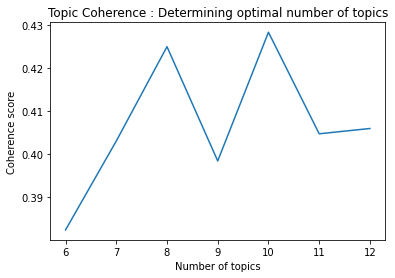

In [71]:
#Plotting number of topics vs. coherence score

plt.plot(grid_search_df['topics'], grid_search_df['coherence score'])
plt.title('Topic Coherence : Determining optimal number of topics')
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.show()

#We see that after 10, the coherence score takes a huge dip. As of now, we can go with 10 topics.

In [72]:
#Running the final lda model with 10 topics

lda_model_10topics = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=10, 
                     random_state=100,
                     chunksize=100,
                     passes=10)

In [73]:
ldatopics = lda_model_10topics.show_topics(formatted=False)

In [74]:
#Top 10 words for each topic

for idx, topic in lda_model_10topics.print_topics():
   print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.027*"community" + 0.017*"make" + 0.014*"program" + 0.013*"per" + 0.012*"people" + 0.010*"family" + 0.009*"time" + 0.009*"difference" + 0.009*"year" + 0.008*"child"
Topic: 1 
Words: 0.020*"student" + 0.012*"please" + 0.012*"work" + 0.012*"hour" + 0.011*"school" + 0.011*"experience" + 0.009*"must" + 0.009*"candidate" + 0.008*"skill" + 0.008*"teaching"
Topic: 2 
Words: 0.024*"camp" + 0.014*"summer" + 0.013*"day" + 0.012*"camper" + 0.010*"staff" + 0.009*"program" + 0.009*"ramapo" + 0.008*"ny" + 0.007*"art" + 0.007*"county"
Topic: 3 
Words: 0.028*"student" + 0.012*"school" + 0.012*"education" + 0.010*"program" + 0.009*"disability" + 0.008*"learning" + 0.008*"employer" + 0.008*"status" + 0.007*"opportunity" + 0.007*"academic"
Topic: 4 
Words: 0.057*"music" + 0.026*"lesson" + 0.024*"student" + 0.018*"de" + 0.012*"teaching" + 0.012*"teacher" + 0.010*"en" + 0.010*"resident" + 0.010*"teach" + 0.009*"piano"
Topic: 5 
Words: 0.034*"student" + 0.028*"director" + 0.022*"program" +

In [75]:
#Determining topic themes looking at the 10 words for each topic:

#Topic 0: Community
#Topic 1: School
#Topic 2: Camp/Summer camp
#Topic 3: Special school
#Topic 4: Music/Other Vocational Courses
#Topic 5: School
#Topic 6: Pre-primary/Daycare
#Topic 7: High School/College
#Topic 8: Sports/Other Vocational Courses
#Topic 9: Nanny/Daycare

In [76]:
#Visualising the topics

pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model_10topics, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.126533 -0.144286       1        1  33.529012
1      0.040575 -0.187770       2        1  17.055651
7      0.181222  0.030739       3        1  12.408979
3      0.154062 -0.030865       4        1  11.539897
2     -0.136515  0.003415       5        1   6.658840
5      0.151719  0.243871       6        1   5.959827
0     -0.063583 -0.003810       7        1   5.029679
9     -0.101219 -0.018405       8        1   2.841360
8     -0.208830 -0.028383       9        1   2.616930
4     -0.143964  0.135494      10        1   2.359826, topic_info=           Term         Freq        Total Category  logprob  loglift
318     student   946.000000   946.000000  Default  30.0000  30.0000
3         child  1067.000000  1067.000000  Default  29.0000  29.0000
285         job   452.000000   452.000000  Default  28.0000  28.0000
74         care   302.000000   302.000000  Default  27.0000  27.0000
47      teacher   719.000000   719.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
201    teaching    25.713609   315.801726  Topic10  -4.4142   1.2385
200       teach    20.603171   172.344997  Topic10  -4.6357   1.6225
47      teacher    24.738715   719.551523  Topic10  -4.4528   0.3763
45       school    11.824928   852.430020  Topic10  -5.1910  -0.5313
480  enthusiasm     9.141309    29.212400  Topic10  -5.4484   2.5848

[657 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
329       1  0.443849     ability
329       2  0.101921     ability
329       3  0.338640     ability
329       4  0.055892     ability
329       6  0.036165     ability
...     ...       ...         ...
217       9  0.017739        year
217      10  0.008869        year
218       7  0.974749         yet
1589      3  0.993079       youth
4302      6  0.982957  youthbuild

[1241 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 8, 4, 3, 6, 1, 10, 9, 5])

In [77]:
#Finding the dominant topic for each job description by topic number that has the highest percentage contribution in that document.

dominant_topic=[]
index=0
for i in lda_model_10topics[corpus]:
  #print('Job description :', index, max(i,key=itemgetter(1))[0])
  dominant_topic.append(max(i,key=itemgetter(1))[0])
  index+=1

In [78]:
#Creating a new column in the dataset for the dominant topic

df['dominant topic'] = dominant_topic

In [79]:
df.head()

,Posting Title,lemmatized description,final cleaned posting text,cluster,dominant topic
0,nursery staff needed at app ski mtn.,"[app, ski, mtn, currently, hiring, nursery, st...",app ski mtn currently hiring nursery staff ski...,9,3
1,challenge island steam enrichment franchise,"[challenge, island, looking, add, franchise, a...",challenge island looking add franchise across ...,7,7
2,making a difference in the black community. pa...,"[blackowned, organization, focus, spreading, a...",blackowned organization focus spreading awaren...,8,0
3,childcare teacher,"[early, childhood, education, toddler, year, o...",early childhood education toddler year old tea...,6,6
4,experience childcare teachers & van drivers ne...,"[childcare, teacher, general, maintenance, van...",childcare teacher general maintenance van driv...,6,6


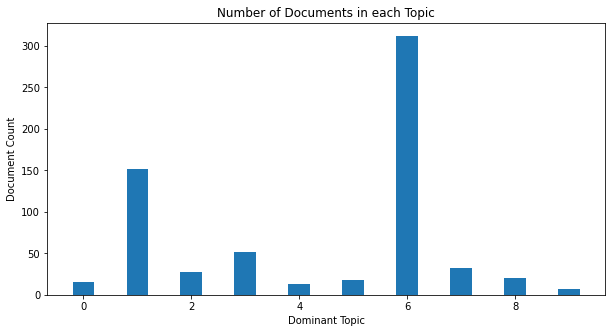

In [80]:
#bar chart
df_bar = pd.DataFrame(df['dominant topic'].value_counts())
df_bar = df_bar.reset_index()
df_bar.columns = ['Dominant Topic','Document Count']
fig = plt.figure(figsize = (10,5))
plt.bar(df_bar['Dominant Topic'], df_bar['Document Count'],
        width = 0.4)
plt.xlabel("Dominant Topic")
plt.ylabel("Document Count")
plt.title("Number of Documents in each Topic")
plt.show()

HDP

In [81]:
#Using HDP method to model topics in the data

hdpmodel = HdpModel(corpus=corpus, id2word=id2word, random_state=23)
hdptopics = hdpmodel.show_topics(formatted=False)

In [82]:
hdptopics[0]

(0,
 [('student', 0.012132949429429123),
  ('teacher', 0.006472030698282868),
  ('experience', 0.00601063601833813),
  ('school', 0.005977611225161381),
  ('child', 0.005912023234625798),
  ('program', 0.005828265916128721),
  ('work', 0.005250013163887784),
  ('job', 0.005054675585309411),
  ('education', 0.004877081417492139),
  ('day', 0.004228126837871926),
  ('skill', 0.00416674966873477),
  ('family', 0.003861403018036352),
  ('staff', 0.0037821515069336323),
  ('hour', 0.003674054436373395),
  ('team', 0.0036551139322811396),
  ('teaching', 0.0035020430151014113),
  ('position', 0.003226940477257104),
  ('support', 0.00318284619678328),
  ('year', 0.003050766588932937),
  ('required', 0.002952398171946259)])

In [83]:
#Comparing LDA and HDP for Coherence Score

hdptopics_cv = [[word for word, prob in topic] for topicid, topic in hdptopics]
#len(hdptopics_cv) 20
ldatopics_cv = [[word for word, prob in topic] for topicid, topic in ldatopics]
#len(ldatopics_cv) 10

In [84]:
lda_coherence = CoherenceModel(topics=ldatopics_cv, texts=lemmatized_description, dictionary=id2word, coherence='c_v').get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics_cv, texts=lemmatized_description, dictionary=id2word,  coherence='c_v').get_coherence()

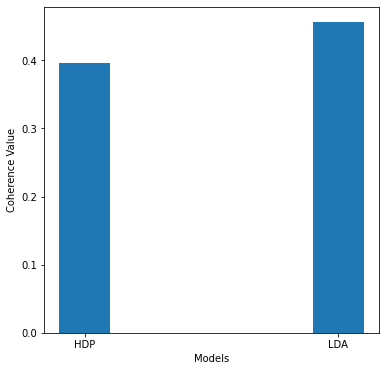

In [85]:
def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.figure(figsize=(6,6))
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

#The coherence score amongst topics is higher for LDA then HDP.
evaluate_bar_graph([hdp_coherence, lda_coherence], ['HDP', 'LDA'])

MODELS

In [86]:
#Splitting the data in train and Test
X_train,X_test,y_train,y_test = train_test_split(df['final cleaned posting text'],df['cluster'], random_state = 23)

#vectorizer
X_train_Tfidf = vectorizer.fit_transform(X_train)
X_test_Tfidf = vectorizer.transform(X_test)

In [87]:
X_test_Tfidf.shape

(163, 7399)

In [88]:
#Defining models

param_grid = {'C': [0.1, 1, 10, 100, 1000],
      'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
      'kernel': ['rbf']}

models = [
    RandomForestClassifier(n_estimators=500, max_depth=8, random_state=23),
    LinearSVC(random_state=23),
    MultinomialNB(),
    LogisticRegression(random_state=23),
    DecisionTreeClassifier(random_state=23),
    GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
]

df_model_accuracy = pd.DataFrame(['RandomForest','LinearSVC','NB','Logit','DecisionTree','GridSearchCV'],columns=['Models'])

In [89]:
df_model_accuracy

,Models
0,RandomForest
1,LinearSVC
2,NB
3,Logit
4,DecisionTree
5,GridSearchCV


In [90]:
model_accuracy = []

for model in models:
  model_name = model_name = model.__class__.__name__
  model.fit(X_train_Tfidf,y_train)
  y_pred = model.predict(X_test_Tfidf)
  accuracy = accuracy_score(y_test, y_pred)
  model_accuracy.append(accuracy)
  
df_model_accuracy['Accuracy'] = model_accuracy

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.265 total time=   0.4s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.268 total time=   0.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.268 total time=   0.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.258 total time=   0.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.268 total time=   0.4s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.265 total time=   0.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.268 total time=   0.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.268 total time=   0.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.258 total time=   0.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.268 total time=   0.7s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.265 total time=   0.7s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [91]:
df_model_accuracy

,Models,Accuracy
0,RandomForest,0.478528
1,LinearSVC,0.852761
2,NB,0.546012
3,Logit,0.748466
4,DecisionTree,0.570552
5,GridSearchCV,0.840491


In [92]:
#Using LinearSVC and tuning the hyperparameters

LinSVC = LinearSVC()
LinSVC.fit(X_train_Tfidf,y_train)
y_pred_SVC = LinSVC.predict(X_test_Tfidf)
accuracy = accuracy_score(y_test, y_pred_SVC)
accuracy

0.852760736196319

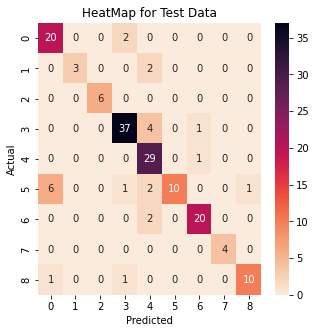

In [94]:
conf_mat = confusion_matrix(y_test, y_pred_SVC)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap = sns.cm.rocket_r)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('HeatMap for Test Data')
plt.show()

BERT MODEL

In [ ]:
!pip install transformers
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup

# Subsetting 2 columns for bert analysis
df_bert = df[['final cleaned posting text', 'cluster']]
df_bert.reset_index(inplace=True,drop=True)
df_bert.head()

# Rename columns
df_bert = df_bert.rename(columns = {'final cleaned posting text':'text','cluster':'label'})
df_bert.head()

X_train, X_val, y_train, y_val = train_test_split(df_bert.index.values,
                                                  df_bert.label.values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=df_bert.label.values)

df_bert['data_type'] = ['not_set']*df_bert.shape[0]

df_bert.loc[X_train, 'data_type'] = 'train'
df_bert.loc[X_val, 'data_type'] = 'val'

df_bert.groupby(['text', 'label', 'data_type']).count()

#tokenize and encode for bert input
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    df_bert[df_bert.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df_bert[df_bert.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_bert[df_bert.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df_bert[df_bert.data_type=='val'].label.values)

# Split for train,test
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

#define Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=10,
                                                      output_attentions=False,
                                                      output_hidden_states=False)


batch_size = 3

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

#Define Optimizer
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

#Define Accuracy Metric
label_dict = {0:'a',1:'b',2:'c',3:'d',4:'e',5:'f',6:'g',7:'h',8:'i',9:'j'}
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

#Train Model
import random

seed_val = 23
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'/content/drive/My Drive/AUD Project/finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

#Predict Results and Get Accuracy
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=10,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/content/drive/My Drive/AUD Project/finetuned_BERT_epoch_3.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)


In [95]:
train_vecs = []
for i in range(len(df)):
    top_topics = (
        lda_model_10topics.get_document_topics(corpus[i],
                                      minimum_probability=0.0))
    topic_vec = [top_topics[i][1] for i in range(9)]
    train_vecs.append(topic_vec)

In [96]:
index_list = []
for i in train_vecs:
    ind = np.argmax(i)
    index_list.append(ind)

In [97]:
lda_model_10topics

In [98]:
lda_top10_data = lda_model_10topics.print_topics(10, num_words=5)[:10]

In [99]:
overall_topics = []
overall_missed_words = []
for i in range(len(df['final cleaned posting text'])):
    try:
        missing_words = []
        print(df['final cleaned posting text'][i])
        print('The recommended topic is ', lda_model_10topics.print_topics(10, num_words=10)[:10][index_list[i]])
        for j in re.findall(r'"([^"]*)"',lda_top10_data[index_list[i]][1]):
            if j not in list(df['lemmatized description'][i]):
                print(j, 'is not in the review despite being in the top recommended topic, do you want to reconsider?')
                missing_words.append(j)
        overall_topics.append(lda_model_10topics.print_topics(10, num_words=10)[:10][index_list[i]])
        overall_missed_words.append(missing_words)
    except:
        overall_topics.append('None')
        overall_missed_words.append('None')
        continue
df['Topics_assigned'] = overall_topics
df['Missing_words'] =  overall_missed_words

app ski mtn currently hiring nursery staff ski season duty include oversight nursery program child age operating apply person app ski mtn main office day week
The recommended topic is  (3, '0.028*"student" + 0.012*"school" + 0.012*"education" + 0.010*"program" + 0.009*"disability" + 0.008*"learning" + 0.008*"employer" + 0.008*"status" + 0.007*"opportunity" + 0.007*"academic"')
student is not in the review despite being in the top recommended topic, do you want to reconsider?
school is not in the review despite being in the top recommended topic, do you want to reconsider?
education is not in the review despite being in the top recommended topic, do you want to reconsider?
disability is not in the review despite being in the top recommended topic, do you want to reconsider?
challenge island looking add franchise across country teacher love kid challenge island might right franchise entrepreneur magazine named challenge island one top franchise world run inschool field trip school progra

In [100]:
overall_missed_words = []
for i in range(len(df['final cleaned posting text'])):
    try:
        missing_words = []
        print(df['final cleaned posting text'][i])
        print('The recommended cluster is ',df['cluster'][i], cluster_terms_list[int(df['cluster'][i])])
        for j in cluster_terms_list[int(df['cluster'][i])]:
            if j not in list(df['lemmatized description'][i]):
                print(j, 'is not in the review despite being in the top recommended topic, do you want to reconsider?')
                missing_words.append(j)
        overall_missed_words.append(missing_words)
    except:
        overall_topics.append('None')
        overall_missed_words.append('None')
        continue
df['Missing_words_cluster'] =  overall_missed_words

Streaming output truncated to the last 5000 lines.
teach is not in the review despite being in the top recommended topic, do you want to reconsider?
dance is not in the review despite being in the top recommended topic, do you want to reconsider?
teacher is not in the review despite being in the top recommended topic, do you want to reconsider?
class is not in the review despite being in the top recommended topic, do you want to reconsider?
hour is not in the review despite being in the top recommended topic, do you want to reconsider?
time is not in the review despite being in the top recommended topic, do you want to reconsider?
experience is not in the review despite being in the top recommended topic, do you want to reconsider?
piano is not in the review despite being in the top recommended topic, do you want to reconsider?
want is not in the review despite being in the top recommended topic, do you want to reconsider?
thanks checking posting looking musical partner join music comp

In [101]:
df.rename(columns = {'Missing_words':'Missing_words_topic_modelling'}, inplace=True)

In [102]:
df

,Posting Title,lemmatized description,final cleaned posting text,cluster,dominant topic,Topics_assigned,Missing_words_topic_modelling,Missing_words_cluster
0,nursery staff needed at app ski mtn.,"[app, ski, mtn, currently, hiring, nursery, st...",app ski mtn currently hiring nursery staff ski...,9,3,"(3, 0.028*""student"" + 0.012*""school"" + 0.012*""...","[student, school, education, disability]","[nanny, family, job, pm, care, paid, work, hou..."
1,challenge island steam enrichment franchise,"[challenge, island, looking, add, franchise, a...",challenge island looking add franchise across ...,7,7,"(7, 0.014*""support"" + 0.014*""family"" + 0.012*""...","[support, youth, team]","[music, chess, instructor, sale, student, less..."
2,making a difference in the black community. pa...,"[blackowned, organization, focus, spreading, a...",blackowned organization focus spreading awaren...,8,0,"(0, 0.027*""community"" + 0.017*""make"" + 0.014*""...",[],"[per child, make difference]"
3,childcare teacher,"[early, childhood, education, toddler, year, o...",early childhood education toddler year old tea...,6,6,"(6, 0.032*""child"" + 0.018*""teacher"" + 0.012*""e...","[child, experience, school]","[must, child, daycare, least, please, assistan..."
4,experience childcare teachers & van drivers ne...,"[childcare, teacher, general, maintenance, van...",childcare teacher general maintenance van driv...,6,6,"(6, 0.032*""child"" + 0.018*""teacher"" + 0.012*""e...","[child, year, school]","[year, child, daycare, least, assistant, looki..."
...,...,...,...,...,...,...,...,...
677,spring 2023 - student research assistant/inter...,"[looking, undergraduate, student, msu, work, u...",looking undergraduate student msu work u eyetr...,5,9,"(1, 0.020*""student"" + 0.012*""please"" + 0.012*""...","[student, please, school]","[per child, make difference]"
679,lead toddler teacher,"[position, toddler, directress, report, progra...",position toddler directress report program dir...,4,6,"(6, 0.032*""child"" + 0.018*""teacher"" + 0.012*""e...","[child, experience, year]","[full time, de, paid, para, child, preschool, ..."
680,program director,"[position, program, director, report, executiv...",position program director report executive dir...,4,5,"(5, 0.034*""student"" + 0.028*""director"" + 0.022...","[student, director, staff]","[early, education, work, staff, childhood, fam..."
681,community living supports,"[community, living, support, position, private...",community living support position private fami...,5,0,"(0, 0.027*""community"" + 0.017*""make"" + 0.014*""...","[community, make, per, people]","[early, education, work, staff, childhood, fam..."


In [103]:
df['Missing_words_both'] = [set(a) & set(b) for a,b in zip(df['Missing_words_topic_modelling'],df['Missing_words_cluster'])]

In [104]:
df.head(50)

,Posting Title,lemmatized description,final cleaned posting text,cluster,dominant topic,Topics_assigned,Missing_words_topic_modelling,Missing_words_cluster,Missing_words_both
0,nursery staff needed at app ski mtn.,"[app, ski, mtn, currently, hiring, nursery, st...",app ski mtn currently hiring nursery staff ski...,9,3,"(3, 0.028*""student"" + 0.012*""school"" + 0.012*""...","[student, school, education, disability]","[nanny, family, job, pm, care, paid, work, hou...",{}
1,challenge island steam enrichment franchise,"[challenge, island, looking, add, franchise, a...",challenge island looking add franchise across ...,7,7,"(7, 0.014*""support"" + 0.014*""family"" + 0.012*""...","[support, youth, team]","[music, chess, instructor, sale, student, less...",{}
2,making a difference in the black community. pa...,"[blackowned, organization, focus, spreading, a...",blackowned organization focus spreading awaren...,8,0,"(0, 0.027*""community"" + 0.017*""make"" + 0.014*""...",[],"[per child, make difference]",{}
3,childcare teacher,"[early, childhood, education, toddler, year, o...",early childhood education toddler year old tea...,6,6,"(6, 0.032*""child"" + 0.018*""teacher"" + 0.012*""e...","[child, experience, school]","[must, child, daycare, least, please, assistan...","{child, experience}"
4,experience childcare teachers & van drivers ne...,"[childcare, teacher, general, maintenance, van...",childcare teacher general maintenance van driv...,6,6,"(6, 0.032*""child"" + 0.018*""teacher"" + 0.012*""e...","[child, year, school]","[year, child, daycare, least, assistant, looki...","{child, year}"
5,piano teacher positions - flying fingers music,"[flying, finger, music, atlanta, based, inhome...",flying finger music atlanta based inhome music...,7,1,"(1, 0.020*""student"" + 0.012*""please"" + 0.012*""...","[hour, school]","[chess, sale, kid, teach, dance, class, hour, ...",{hour}
6,turning sun schools actively recruiting presch...,"[turning, sun, school, educator, position, ava...",turning sun school educator position available...,5,6,"(6, 0.032*""child"" + 0.018*""teacher"" + 0.012*""e...",[teacher],"[tutor, tutoring, math, must, teaching, skill,...",{}
8,lead ceramics instructor / pottery instructor,"[small, hand, big, art, child, art, studio, de...",small hand big art child art studio delighting...,7,6,None,None,None,"{o, e, N, n}"
9,piano & violin teachers wanted,"[lesson, home, looking, music, teacher, teach,...",lesson home looking music teacher teach piano ...,1,4,"(4, 0.057*""music"" + 0.026*""lesson"" + 0.024*""st...","[music, de]","[music, chess, sale, dance, teacher, piano]",{music}
10,lead teachers needed $16-$18 at tots 2 toddler...,"[tot, toddler, childcare, learning, center, lo...",tot toddler childcare learning center looking ...,4,6,"(6, 0.032*""child"" + 0.018*""teacher"" + 0.012*""e...",[child],"[special education, education, special, direct...",{}


In [105]:
df.to_csv('Scored_data.csv')

In [108]:
import os
os.getcwd()

'/content'

END!

DEMO

In [109]:
job_description='''We are searching for a credible Babysitter to tend to minors during short, often scheduled stretches of caregiver absence. The babysitter should direct feeding tasks, supervise hygiene-related chores, and ensure adherence to stipulated curfews. You should also fortify all vulnerable points at each residence.



To be successful as a babysitter, you should comply with caregivers' stipulated guidelines. An incredible babysitter will co-create a serene and adaptable residential setting while on duty.



Responsibilities:
Reviewing caregivers' instructions and requesting helpful clarification when needed.
Monitoring self-directed feeding, hygiene-related, and tidying activities.
Aiding applicable minors with routine tasks, if required.
Fortifying every access point around dusk.
Encouraging sufficient, cognitively stimulating individual and group play.
Promoting adherence to non-negotiable curfews.
Modeling actions that emulate caregivers' principles, unless deemed inappropriate.
Securing help from medical, familial, and similar structures, as required.
Babysitter Requirements:
High school diploma.
Undisputed legal capacity.
Demonstrable successful babysitting experience.
Own driver's license.
First-hand experience with navigating child-related emergencies is beneficial.
Perceptive to major safety-related threats.
Ability to issue age-appropriate directions.
Observance of caregivers' babysitting-related requests."'''



#pred_test = vec.transform(job_description)
tokenized_description = nltk.word_tokenize(job_description)

stopwords_list = stopwords.words('english')

words_to_add = ['qr','code','link','to','this','post','click','here','http','https']
stopwords_list = stopwords_list + words_to_add

stop_words_removed=[word for word in tokenized_description if word.lower() not in stopwords_list if word.isalpha()]

single_letter_removed=[word for word in stop_words_removed if len(word)!=1]

lemmatized_words=[lemmatizer.lemmatize(word.lower()) if word.isalpha() else word.lower() for word in single_letter_removed]

final_cleaned_text = ' '.join(lemmatized_words)
final_cleaned_text =[final_cleaned_text]
#print(single_letter_removed,lemmatized_words)

test_case = vectorizer.transform(final_cleaned_text)
#print(test_case.toarray())


y_pred_SVC = LinSVC.predict(test_case)
print(y_pred_SVC)

[9]


In [110]:
#K means cluster descriptions:

#Topic 0: Pre-School/Pre-Primary
#Topic 1: Special education
#Topic 2: Substitute
#Topic 3: Summer camp
#Topic 4: Primary
#Topic 5: High-School/College
#Topic 6: Daycare
#Topic 7: Vocational Training
#Topic 8: Community/Non-Profit
#Topic 9: Nanny/Caregiver

END!